In [1]:
import itertools
import random
import numpy as np
import more_itertools
from matplotlib import pyplot as plt

def fact(n):
    if n==0:
        return 1
    else:
        return n*fact(n-1)

In [15]:
def generate_votes(n_voters, n_candidates):
    votes = []
    candidates = [i for i in range(n_candidates)]
    for i in range(n_voters):
        random.shuffle(candidates)
        votes.append(list(candidates))
    return votes

In [585]:
def majority(votes):
    n_candidates = len(votes[0])
    candidates = set(votes[0])
    wins = {i: 0 for i in candidates}
    for i in range(len(votes)):
        wins[votes[i][0]]+=1
    return wins

def one_to_one(votes):
    n_candidates = len(votes[0])
    wins = [0]*n_candidates
    for i in range(len(votes)):
        for j in range(n_candidates-1):
            wins[votes[i][j]]+=n_candidates-j-1
    return wins

def condorcet(votes):
    n_candidates = len(votes[0])
    wins = [[0 for _ in range(n_candidates)] for _ in range(n_candidates)]
    for i in range(len(votes)):
        for j in range(n_candidates):
            a = votes[i][j]
            for k in range(j+1, n_candidates):
                b = votes[i][k]
                wins[a][b]+=1
    scores = [0 for _ in range(n_candidates)]
    for i in range(n_candidates):
        for j in range(i+1, n_candidates):
            if wins[i][j]>wins[j][i]:
                scores[i]+=1
            if wins[j][i]>wins[i][j]:
                scores[j]+=1
    return scores

def remove(index, votes):
    return [[item for item in row if item != index] for row in votes]
    
def irv(votes):
    wins = majority(votes)
    total_sum = sum(wins.values())
    maj = {key: value / total_sum for key, value in wins.items()}
    new_votes = list(votes)
    while maj[max(maj, key=maj.get)]<=0.5:
        lowest = min(maj, key=maj.get)
        new_votes = remove(lowest, new_votes)
        wins = majority(new_votes)
        maj = {key: value / total_sum for key, value in wins.items()}
    return max(maj, key=maj.get)

def borda(votes):
    n_candidates = len(votes[0])
    wins = [0 for _ in range(n_candidates)]
    for i in range(len(votes)):
        for j in range(n_candidates):
            wins[votes[i][j]]+=(n_candidates-j)
    return wins

# Voting criteria:

#### Majority Criterion: If more than half of the voters prefer one candidate over all others, that candidate should be the winner.

#### Condorcet Criterion: If a candidate is preferred over every other candidate in pairwise comparisons, that candidate should be the winner.

#### Monotonicity criterion: If a voter raises the preference of a candidate, that candidate should not be harmed in the election outcome. Conversely, if a voter lowers the preference of a candidate, that candidate should not be benefited.

#### Independence of Irrelevant Alternatives (IIA): If a non-winning candidate is removed from the ballot, it should not change the winner of the election

### Plurality winner != Condorcet winner and IRV winner != Plurality winner

In [586]:
v = [[0,2,1,3],[1,3,2,0],[1,2,3,0],[2,1,3,0],[2,1,0,3],[0,1,3,2],[0,2,1,3]] # rows=voters, columns=candidates
v

[[0, 2, 1, 3],
 [1, 3, 2, 0],
 [1, 2, 3, 0],
 [2, 1, 3, 0],
 [2, 1, 0, 3],
 [0, 1, 3, 2],
 [0, 2, 1, 3]]

In [587]:
print('Plurality:')
print(list(majority(v).values()))
print('------')
print('Condorcet:')
print(condorcet(v))
print('------')
print('IRV:')
print(irv(v))
print('------')
print('Borda:')
print(borda(v))

Plurality:
[3, 2, 2, 0]
------
Condorcet:
[1, 2, 3, 0]
------
IRV:
2
------
Borda:
[17, 21, 20, 12]


### Borda can contradict Majority Criterion

In [588]:
v = [[1,2,0],[1,2,0],[1,2,0],[2,0,1],[2,0,1]] # rows=voters, columns=candidates
np.array(v)

array([[1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [2, 0, 1],
       [2, 0, 1]])

In [589]:
print('Plurality:')
print(list(majority(v).values()))
print('------')
print('Condorcet:')
print(condorcet(v))
print('------')
print('IRV:')
print(irv(v))
print('------')
print('Borda:')
print(borda(v))

Plurality:
[0, 3, 2]
------
Condorcet:
[0, 2, 1]
------
IRV:
1
------
Borda:
[7, 11, 12]


# Power index: numerical way of looking at power in a weighted voting system

In [2]:
def shap(weights, quota):
    n_players = len(weights)
    coalitions = [set(subset) for subset in more_itertools.powerset([i for i in range(n_players)])]
    shapley_value = [0]*n_players
    for i in range(n_players):
        k=0
        for c in coalitions:
            if i not in c:
                a=0
                for j in c:
                    a+=weights[j]
                aq = np.sum(a)>=quota
                ai = (np.sum(a)+weights[i])>=quota
                k += fact(len(c))*fact(n_players-len(c)-1)*(ai*1 - 1*aq)
        shapley_value[i] = k/fact(n_players)
    return np.array(shapley_value)
    

def ban(weights, quota):
    n_players = len(weights)
    banzhaf_index = [0]*n_players
    coalitions = [set(subset) for subset in more_itertools.powerset([i for i in range(n_players)])]
    for c in coalitions:
        if np.sum([weights[i] for i in c])<quota:
            continue
        for player in c:
            new_c = c.copy()
            new_c.discard(player)
            if np.sum([weights[i] for i in new_c])<quota:
                banzhaf_index[player]+=1
    return np.array(banzhaf_index)/np.sum(banzhaf_index)


def ss(weights, quota):
    n_players = len(weights)
    coalitions = list(itertools.permutations([i for i in range(n_players)]))

    shapley_shubik_index = [0]*n_players

    for c in coalitions:
        s = 0
        for player in c:
            s = s+weights[player]
            if s>=quota:
                shapley_shubik_index[player]+=1
                break
    return np.array(shapley_shubik_index)/np.sum(shapley_shubik_index)


In [19]:
diff12 = 0
diff13 = 0
diff23 = 0
for i in range(1000):
    for j in range(2,8):
        weights = np.abs(np.random.uniform(1,j*2,j)//1)
        quota = np.sum(weights)//2+1

        result_1 = ban(weights, quota).reshape(j,)
        result_2 = ss(weights, quota).reshape(j,)
        result_3 = shap(weights, quota).reshape(j,)
        
        diff12+= np.sum(np.abs(result_1-result_2))
        diff23+= np.sum(np.abs(result_2-result_3))
        diff13+= np.sum(np.abs(result_1-result_3))


In [20]:
print(diff12)
print(diff13)
print(diff23)

117.41187515985584
117.41187515985584
0.0


In [28]:
weights = np.array([1,1,1,3])
quota = np.sum(weights)//2+1

result_1 = ban(weights, quota)
result_2 = ss(weights, quota)

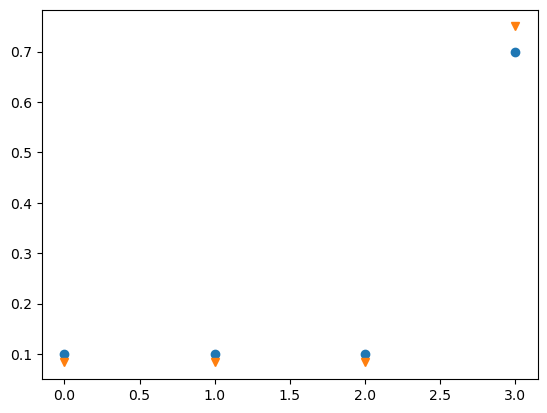

In [29]:
plt.plot(result_1,'o', result_2,'v')
plt.show()

In [30]:
result_1

array([0.1, 0.1, 0.1, 0.7])

In [31]:
result_2

array([0.08333333, 0.08333333, 0.08333333, 0.75      ])

In [33]:
quota

4

# Keywords:

#### Quota: minimum number of votes for a proposal to be approved (should be more than half of the weights)

#### Dictator: if weight[player]>quota, then player is dictator

#### Veto power: if a player is needed for the quota to be reached, then he has veto power

#### Dummy voter: if a player is never essential to reach quota, then he is a dummy player

#### Winning coalition: a colation that can reach quota

#### Critical player: within a winning coalition if a player leaves and the coalition is no longer winning, then he is a critical player

In [21]:
def norm(x, k):
    y = np.array(x)
    if k==-1:
        m1 = max(np.max(y), 1)
        m2 = min(np.min(y), -1)
        m = max(np.abs(m1), np.abs(m2))
        return y/m
    if k==0:
        m = max(np.max(y),1)
        a = 1/(2*m)
        return a*y+0.5-1/(4*m)


def est3(v, iterations, target):
    nq, nv = v.shape
    trust = 0.4 * np.ones((1, nv))
    diff = 0.1 * np.ones((nq, 1))
    target.shape = (nq, 1)
    y = np.ones((nq, 1))

    t = (v == 1)
    t_ = (v == -1)
    
    for it in range(iterations):
        n = np.sum(v ** 2, 1)
        pos = np.sum(t * (1 - np.matmul(diff, trust)), 1)
        neg = np.sum(t_ * np.matmul(diff, trust), 1)
        y = (pos + neg) / n
        y.shape = (nq, 1)
        m1 = np.max(y)
        m2 = np.min(y)
        m = max(np.abs(m1-0.5), np.abs(m2-0.5))
        a = 1/(2*m)
        y= a*y+0.5-1/(4*m)

        n = np.sum(v ** 2, 1)
        pos = np.sum(t * np.matmul((1 - y), 1 / trust), 1)
        neg = np.sum(t_ * np.matmul(y, 1 / trust), 1)
        n.shape = pos.shape
        diff = (pos + neg) / n
        diff.shape = (nq, 1)
        diff = norm(diff, 0)

        n = np.sum(v ** 2, 0)
        pos = np.matmul(t.transpose(), (1 - y) / diff)
        neg = np.matmul(t_.transpose(), y / diff)
        n.shape = pos.shape
        trust = (pos + neg) / n
        trust.shape = (1, nv)
        trust = norm(trust, 0)

    print('accuracy ', 100*np.mean((y >= 0.5) == (target>=0)),'%')    
    return y, trust, diff

def cosine(votes, iterations, target):
    v = votes.transpose()
    t = (v == 1)
    t_ = (v == -1)
    nv, nq = v.shape
    error = []

    N = np.sum(v != 0, 1)  # Number of {votes!=0}
    trust = (np.sum(t, 1) - np.sum(t_, 1)) / N
    trust.shape = (nv, 1)
    N.shape = trust.shape
    y = np.ones((nq, 1))
    target.shape = y.shape
    
    eta = 0.5
    
    for iteration in range(iterations):
        pos = np.matmul(t, y)
        neg = np.matmul(t_, y)
        norm = np.matmul((v != 0), y ** 2) * N
        norm = np.sqrt(norm)
        new_trust = (pos - neg) / norm
        trust = trust * (1 - eta) + new_trust * eta

        pos = np.matmul(t.transpose(), (trust**3))
        neg = np.matmul(t_.transpose(), (trust**3))
        norm = pos + neg
        y = (pos - neg) / norm
        
        m1 = np.max(y)
        m2 = np.min(y)
        m = max(np.abs(m1), np.abs(m2))
        y = y/m
        
    print('accuracy ', 100*np.mean((y >= 0) == (target>=0)),'%')  
    return y, trust

def crh(votes, iterations, target):
    nq, nv = v.shape
    
    y = 2*(np.mean(votes,1)>=0)-1
    
    for iteration in range(iterations):
        d = ((v-np.tile(y.reshape(nq,1), (1,nv)))**2)/np.tile(np.std(v,1).reshape(nq,1), (1,nv))
        c = np.sum(d)
        trust = -np.log(np.sum(d,0)/c)
        y = np.sum(trust.reshape(1,nv)*v,1)/np.sum(trust)
    
    y.shape = target.shape
    print('accuracy ', 100*np.mean((y >= 0) == (target>=0)),'%')  
    return y, trust

def crh2(votes, iterations, target):
    nq, nv = v.shape
    
    y = 2*(np.mean(votes,1)>=0)-1
    
    for iteration in range(iterations):
        d = ((v-np.tile(y.reshape(nq,1), (1,nv)))**2)/np.tile(np.std(v,1).reshape(nq,1), (1,nv))
        c = np.sum(d)
        trust = np.sqrt(np.sum(d,0)/c)
        y = np.sum(trust.reshape(1,nv)*v,1)/np.sum(trust)
    
    y.shape = target.shape
    print('accuracy ', 100*np.mean((y >= 0) == (target>=0)),'%')  
    return y, trust

In [22]:
target = np.random.binomial(1,0.5,(1000,))

v = []
for player in range(20):
    vote = np.random.binomial(1,0.4+player/50,1000)
    vote = 1-(vote + target -2*vote*target)
    v.append(vote)
v = 2*np.array(v).transpose()-1
no = np.random.binomial(1,0.99,v.shape)
v = v*no
target = 2*target - 1
target_2= 2*(np.sum(v,1)>=0)-1
print(np.mean((target >= 0) == (target_2>=0))*100, '% accuracy with majority voting')

81.3 % accuracy with majority voting


accuracy  70.8 %


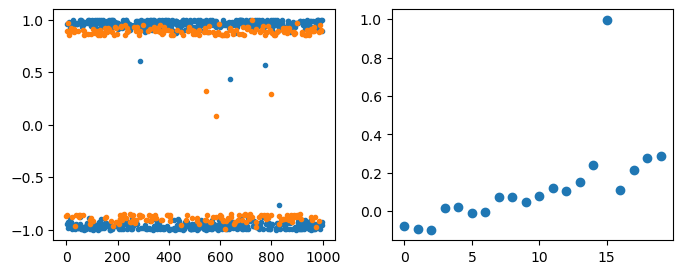

In [23]:
a, b = cosine(v, 10 , target)
x = np.array([i for i in range(1000)]).reshape(1000,1)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x[(a>=0)==(target>=0)], a[(a>=0)==(target>=0)], '.',x[(a>=0)!=(target>=0)], a[(a>=0)!=(target>=0)], '.')
plt.subplot(1,2,2)
plt.plot(b, 'o')
plt.show()

accuracy  85.1 %


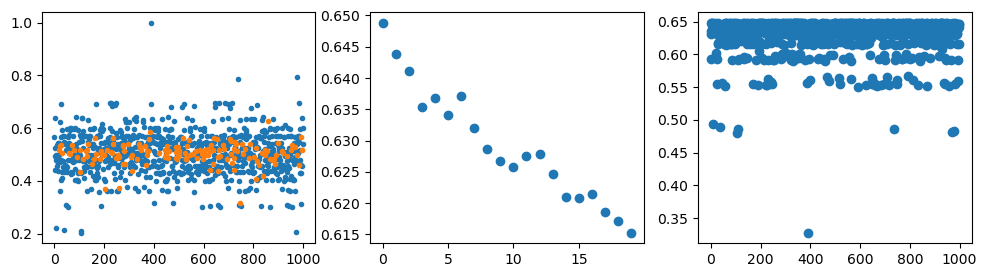

In [24]:
a, b, c = est3(v, 10, target)
x = np.array([i for i in range(1000)]).reshape(1000,1)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(x[(a>=0.5)==(target>=0)], a[(a>=0.5)==(target>=0)], '.',x[(a>=0.5)!=(target>=0)], a[(a>=0.5)!=(target>=0)], '.')
plt.subplot(1,3,2)
plt.plot(b.transpose(), 'o')
plt.subplot(1,3,3)
plt.plot(c, 'o')
plt.show()

accuracy  85.1 %


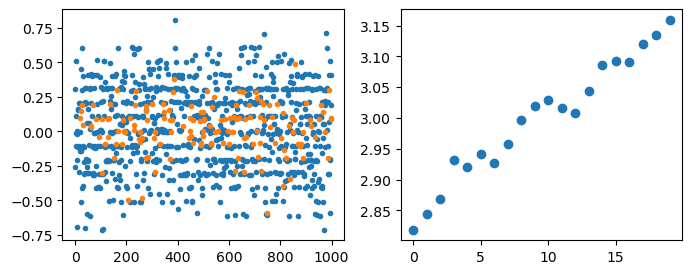

In [25]:
a, b = crh(v, 10 , target)
x = np.array([i for i in range(1000)]).reshape(target.shape)
a.shape = target.shape
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x[(a>=0)==(target>=0)], a[(a>=0)==(target>=0)], '.',x[(a>=0)!=(target>=0)], a[(a>=0)!=(target>=0)], '.')
plt.subplot(1,2,2)
plt.plot(b, 'o')
plt.show()

accuracy  78.3 %


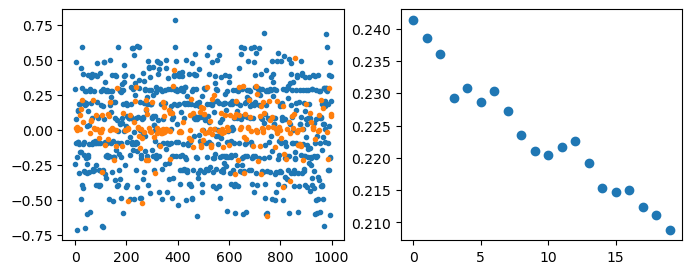

In [26]:
a, b = crh2(v, 10 , target)
x = np.array([i for i in range(1000)]).reshape(target.shape)
a.shape = target.shape
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x[(a>=0)==(target>=0)], a[(a>=0)==(target>=0)], '.',x[(a>=0)!=(target>=0)], a[(a>=0)!=(target>=0)], '.')
plt.subplot(1,2,2)
plt.plot(b, 'o')
plt.show()

In [39]:
target = np.random.binomial(1,0.5,(1000,))

v = []
for player in range(20):
    vote = np.random.binomial(1,0.5+player/45,1000)
    vote = 1-(vote + target -2*vote*target)
    v.append(vote)
v = 2*np.array(v).transpose()-1
no = np.random.binomial(1,0.5,v.shape)
v = v*no
target = 2*target - 1
target_2= 2*(np.sum(v,1)>=0)-1
print(np.mean((target >= 0) == (target_2>=0))*100, '% accuracy with majority voting')


91.2 % accuracy with majority voting


accuracy  95.89999999999999 %


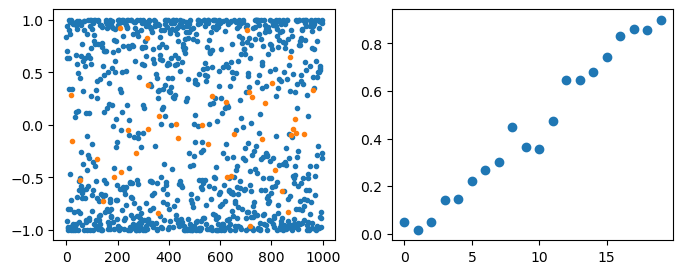

In [40]:
a, b = cosine(v, 1000 , target)
x = np.array([i for i in range(1000)]).reshape(1000,1)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x[(a>=0)==(target>=0)], a[(a>=0)==(target>=0)], '.',x[(a>=0)!=(target>=0)], a[(a>=0)!=(target>=0)], '.')
plt.subplot(1,2,2)
plt.plot(b, 'o')
plt.show()

accuracy  93.0 %


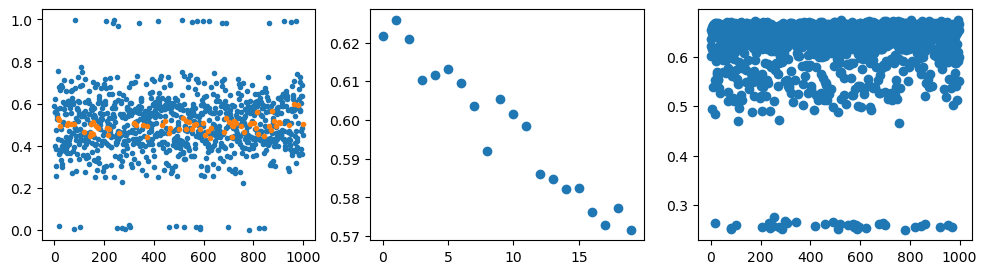

In [41]:
a, b, c = est3(v, 1000, target)
x = np.array([i for i in range(1000)]).reshape(1000,1)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(x[(a>=0.5)==(target>=0)], a[(a>=0.5)==(target>=0)], '.',x[(a>=0.5)!=(target>=0)], a[(a>=0.5)!=(target>=0)], '.')
plt.subplot(1,3,2)
plt.plot(b.transpose(), 'o')
plt.subplot(1,3,3)
plt.plot(c, 'o')
plt.show()

accuracy  92.9 %


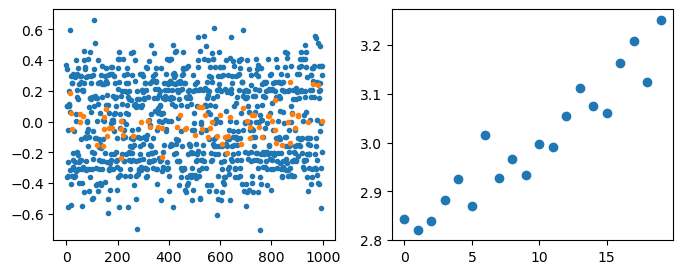

In [42]:
a, b = crh(v, 1000 , target)
x = np.array([i for i in range(1000)]).reshape(target.shape)
a.shape = target.shape
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x[(a>=0)==(target>=0)], a[(a>=0)==(target>=0)], '.',x[(a>=0)!=(target>=0)], a[(a>=0)!=(target>=0)], '.')
plt.subplot(1,2,2)
plt.plot(b, 'o')
plt.show()

# Truth-Finding Weights and Power Index

In [43]:
target = np.random.binomial(1,0.5,(1000,))

v = []
for player in range(6):
    vote = np.random.binomial(1,0.5+player/12,1000)
    vote = 1-(vote + target -2*vote*target)
    v.append(vote)
v = 2*np.array(v).transpose()-1
no = np.random.binomial(1,0.9,v.shape)
v = v*no
target = 2*target - 1
target_2= 2*(np.sum(v,1)>=0)-1
print(np.mean((target >= 0) == (target_2>=0))*100, '% accuracy with majority voting')


86.5 % accuracy with majority voting


accuracy  89.7 %


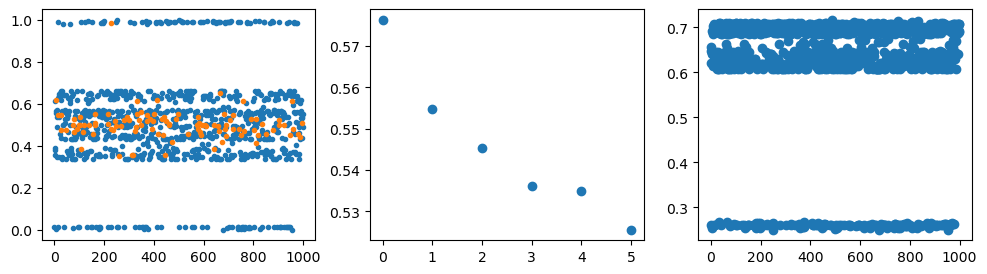

In [49]:
a, b, c = est3(v, 10, target)
x = np.array([i for i in range(1000)]).reshape(1000,1)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(x[(a>=0.5)==(target>=0)], a[(a>=0.5)==(target>=0)], '.',x[(a>=0.5)!=(target>=0)], a[(a>=0.5)!=(target>=0)], '.')
plt.subplot(1,3,2)
plt.plot(b.transpose(), 'o')
plt.subplot(1,3,3)
plt.plot(c, 'o')
plt.show()

In [68]:
weights = b[0]*10000000//1
#weights = np.array([1,4,2])
print('weights: ', weights)
quota = np.sum(weights)//2+1
print('quota: ', quota)
if quota<np.sum(weights)/2 or quota>np.sum(weights):
    print(np.sum(weights)/2,np.sum(weights))
    print("Quota is too low or too high")
n_players = len(weights)

weights:  [5763777. 5548409. 5453263. 5361154. 5348768. 5255368.]
quota:  16365370.0


In [72]:
5763777+5255368+5348768

16367913

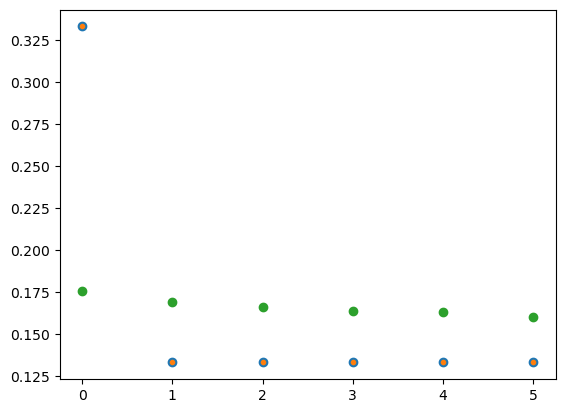

In [73]:
coalitions = [set(subset) for subset in more_itertools.powerset([i for i in range(n_players)])]

banzhaf_index = [0]*n_players

for c in coalitions:
    if np.sum([weights[i] for i in c])<quota:
        continue
    for player in c:
        new_c = c.copy()
        new_c.discard(player)
        if np.sum([weights[i] for i in new_c])<quota:
            banzhaf_index[player]+=1
result_1 = np.array(banzhaf_index)/np.sum(banzhaf_index)

coalitions = list(itertools.permutations([i for i in range(n_players)]))

shapley_shubik_index = [0]*n_players

for c in coalitions:
    s = 0
    for player in c:
        s = s+weights[player]
        if s>=quota:
            shapley_shubik_index[player]+=1
            break
            
result_2 = np.array(shapley_shubik_index)/np.sum(shapley_shubik_index)
result_3 = weights/np.sum(weights)
plt.plot(result_1, 'o', result_2, '.', result_3, 'o')
plt.show()

In [51]:
def f(x,a):
    return np.sum(np.abs(x-a))

def g(x,a):
    return np.abs(np.sum(a)-np.sum(a))

def f(x,a):
    return np.sum((x-a)**2)

def g(x,a):
    return (np.sum(a)-np.sum(a))**2

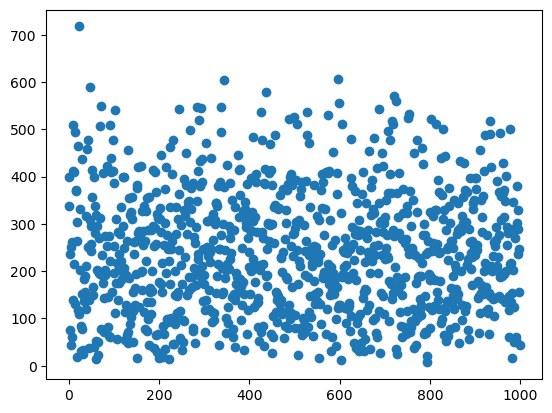

In [52]:
y = []
a = np.random.uniform(0,20,4)
for i in range(1000):
    x = np.random.uniform(0,20,4)
    y.append(f(x,a) - g(x,a))
    
plt.plot(y,'o')
plt.show()

In [60]:
for k in range(10):
    a = np.random.uniform(0,20,5)
    x = np.random.uniform(0,20,5)
    y = np.copy(x)
    for i in range(1000):
        x = x - (x-a)/100
        y = y - np.sum(x-a)/100
    print(x)
    print(y)
    print(f(x,a))
    print(f(y,a))
    print(g(x,a))
    print(g(y,a))
    print('--------------')

[ 9.70546877  1.37337715  4.55004956 14.15267759 16.01816668]
[17.03041647  4.23559091 22.83666213  7.20523655  6.01357434]
9.687854651057098e-07
544.6502835495199
0.0
0.0
--------------
[ 6.71542035  3.26240926 17.4306777   7.76273738  7.04802238]
[-8.05546984 -0.73696006 -5.75666417 -6.86475679  3.33094322]
5.944950333247328e-07
999.6148563569293
0.0
0.0
--------------
[ 7.52753314  2.99261579 13.27225151  2.99679468  4.99367322]
[ 8.17930652  2.94503995  9.95080714 -2.21521456  3.49647012]
4.516853717128709e-08
40.86732774838533
0.0
0.0
--------------
[ 7.32842343  7.33878823 13.59027723 15.97291281 14.83292942]
[ 7.23526093  4.38116653 -0.74588666 11.55057202 11.09254123]
2.341824368418852e-07
247.83667470375593
0.0
0.0
--------------
[ 5.35142445  9.79865475 12.7676039  16.19056091 15.17840904]
[21.86922809 18.65385871  7.41238564 22.42262435 12.43186469]
6.018829103861162e-07
426.3378136544455
0.0
0.0
--------------
[18.4038401  19.24470262  5.92909776 13.67846438  6.4694148 ]
[1

In [54]:
print(x,y)

[ 6.96579645 10.19660078 14.95466448 14.88175341  7.44920925 18.22783808
  8.6597585   0.91785047  3.98797499 18.0534147 ] [19.50171781 15.34184261  7.13768492 20.35310103 19.09794375  2.86412614
 14.8137952  15.52174877  3.11415107  6.44427488]
